In [77]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Time Series Anomaly Detection with LSTM Autoencoders using Keras and TensorFlow2 in Python
by Venelin Valkov
https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

In [78]:
df = pd.read_csv("data/manipulated_data.csv", delimiter=";", header=3, index_col="Date/Time")  # 
""" df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.set_index("Date/Time") """
""" df["Manual outlier"] = -1
df["Manual outlier"][26] = 1
df["Manual outlier"][83] = 1
df["Manual outlier"][122] = 1 """
df.iloc[16618:]


,"Water level, Nap (cm)"
Date/Time,
2023-02-17 05:00:04,32
2023-02-17 05:30:00,32
2023-02-17 06:00:00,35
2023-02-17 06:30:00,35
2023-02-17 07:00:04,35
...,...
2023-03-07 23:00:00,26
2023-03-07 23:30:00,25
2023-03-08 00:00:04,25


In [79]:
df.shape

(17523, 1)

In [80]:
# plt.plot(df, label="Water level, Nap (cm)")

In [81]:
train_size = int(len(df) * .95)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(16646, 1) (877, 1)


In [82]:
from sklearn.preprocessing import StandardScaler
# StandardScaler standardiserar värdena till att bli mellan -1 och 1 och där medelvärdet ligger på 0. 
# scaler.fit() beräknar värdena, och scaler.transform() applicerar dem på datan.
# x_scaled = (x - mean) / std hur många standardavvikelser är std? 

scaler = StandardScaler()
scaler = scaler.fit(train[["Water level, Nap (cm)"]])

In [83]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Water level, Nap (cm)'], dtype=object),
 'n_features_in_': 1,
 'n_samples_seen_': 16646,
 'mean_': array([27.32031719]),
 'var_': array([164.43638524]),
 'scale_': array([12.82327514])}

In [84]:
# Vad händer här? Vi har beräknat scaler utifrån train["water level"], så alla vattennivåvärden i train och test 
# som är 27 blir 0, de därunder blir mindre och de däröver blir större. Eftersom vi inte har minusvärden i 
# datasetet kommer de de flesta värden troligtvis att ligga runt noll, då variansen(?) är hög i förhållande 
# till medelvärdet. Eller hur räknas värdet ut?
train["Water level, Nap (cm)"] = scaler.transform(train[["Water level, Nap (cm)"]])
test["Water level, Nap (cm)"] = scaler.transform(test[["Water level, Nap (cm)"]])

C:\Users\johanna4303\AppData\Local\Temp\ipykernel_620\3062258992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Water level, Nap (cm)"] = scaler.transform(train[["Water level, Nap (cm)"]])
C:\Users\johanna4303\AppData\Local\Temp\ipykernel_620\3062258992.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Water level, Nap (cm)"] = scaler.transform(test[["Water level, Nap (cm)"]])


In [85]:
train.head()

,"Water level, Nap (cm)"
Date/Time,
2022-03-08 00:00:04,-0.258929
2022-03-08 00:30:00,-0.258929
2022-03-08 01:00:00,-0.258929
2022-03-08 01:30:00,-0.570862
2022-03-08 02:00:00,-0.570862


In [86]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)


In [87]:
TIME_STEPS = 1440

X_train, y_train = create_dataset(
    train[["Water level, Nap (cm)"]], 
    train[["Water level, Nap (cm)"]], 
    TIME_STEPS)

X_test, y_test = create_dataset(
    test[["Water level, Nap (cm)"]], 
    test[["Water level, Nap (cm)"]], 
    TIME_STEPS)

In [88]:
model.input_shape

(None, 30, 1)

In [89]:
# När vi skapar ett Sequentialobjekt, läggs alla layers på modellen i den ordning de kommer i koden.
model = keras.Sequential()

# LSTM har en minnescell så att modellen kommer ihåg vad som hänt tidigare i tidssekvensen.
# Den har tre portar: input, output samt forget, vilket gör det lättare att styra vilken information
# som ska flöda vidare. Den här modellen får nu 64 LSTM-celler.
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout slumpar 20% av värdena till 0 (alltså medelvärdet) för att minska risken för overfitting.
model.add(keras.layers.Dropout(rate=0.2))

# Det här lagret repeterar outputen av encodernätverket n antal gånger längs en ny axel, så tensor får 
# en till dimension med värdet från outputen * n(?).
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

# Här returneras output från alla time steps i sekvensen. Default är False. Används ofta i mitten, sällan i slutet.
model.add(keras.layers.LSTM(
    units=64, 
    return_sequences=True))

model.add(keras.layers.Dropout(rate=0.2))

# TimeDistributed gör att lagret inuti appliceras på alla tidssteg oberoende av varandra.
model.add(keras.layers.TimeDistributed(
    # Dense-lagret tar output från LSTM och formar om till ny output av önskad storlek,
    # ofta(?) med en viktmatris, bias vector och genom en aktiveringsfunktion.
    keras.layers.Dense(units=X_train.shape[2]
)))
# Här konfigureras inlärningsprocessen. Optimizern uppdaterar vikter under träning, loss mäter hur väl
# modellen presterar och metrics utvärderar hur väl modellen presterar.
# mae = mean absolute error, mäter hur nära det rätta resultatet modellen kommer. Ingen hänsyn tas till hur 
# stort felet är (absolute, not squared).
# Adam uppdaterar parametrarna, typ. :)
model.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, Dense
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the model architecture
def create_model(num_lstm_units=50, dropout_rate=0.2, lr=0.001, activation='relu'):
    model = Sequential()
    model.add(LSTM(num_lstm_units, input_shape=(timesteps, features)))
    model.add(Dropout(dropout_rate))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(num_lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(features, activation=activation))
    optimizer = Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    return model

# Define the hyperparameter space
param_dist = {
    'num_lstm_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'activation': ['relu', 'sigmoid', 'tanh', 'softmax'],
    "optimizer": ["adam", "rmsprop", "adagrad", "nadam", "adadelta"]  # adagrad är bra när vi har lite data, adadelta passar för noisy gradients
}

# Create a KerasRegressor object
model = KerasRegressor(build_fn=create_model, verbose=0)

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   cv=3, n_iter=10, n_jobs=-1, verbose=1)

# Fit the random search object to the data
random_search_results = random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding MAE score
print("Best MAE score:", -random_search_results.best_score_)
print("Best hyperparameters:", random_search_results.best_params_)

"""

In practice, common batch sizes for training deep learning models typically range from 16 to 512. However, the specific batch size that works best for a particular model and dataset can vary and may require some experimentation.

It's worth noting that the choice of batch size can also affect the learning rate and other hyperparameters of the model. As a general guideline, larger batch sizes may require a larger learning rate to achieve the same level of convergence as smaller batch sizes, and smaller batch sizes may require more regularization to prevent overfitting.

In [90]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
428/428 [==============================] - 722s 2s/step - loss: 0.1572 - val_loss: 0.1440
Epoch 2/10
428/428 [==============================] - 676s 2s/step - loss: 0.1213 - val_loss: 0.0815
Epoch 3/10
428/428 [==============================] - 685s 2s/step - loss: 0.1074 - val_loss: 0.0944
Epoch 4/10
428/428 [==============================] - 754s 2s/step - loss: 0.1143 - val_loss: 0.1000
Epoch 5/10
428/428 [==============================] - 711s 2s/step - loss: 0.1099 - val_loss: 0.0837
Epoch 6/10
428/428 [==============================] - 687s 2s/step - loss: 0.1080 - val_loss: 0.0972
Epoch 7/10
428/428 [==============================] - 706s 2s/step - loss: 0.1097 - val_loss: 0.0818
Epoch 8/10
428/428 [==============================] - 737s 2s/step - loss: 0.1080 - val_loss: 0.0930
Epoch 9/10
428/428 [==============================] - 740s 2s/step - loss: 0.1052 - val_loss: 0.0829
Epoch 10/10
428/428 [==============================] - 738s 2s/step - loss: 0.1032 - val_lo

In [95]:
model.save("models/230411")


INFO:tensorflow:Assets written to: models/230411\assets


INFO:tensorflow:Assets written to: models/230411\assets


 Layer (type)                Output Shape              Param #   
=================================================================
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted) 
 

In [15]:
lr = model.optimizer.learning_rate
lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [96]:
# Är det rimligt att den är så mycket sämre på testdelen 0.2536 (som är 5%) än träningsdelen 0.1099?
metrics_result = history.model.evaluate(X_test, y_test)
metrics_result.real

c:\lia-outlier-detection\venv\Lib\site-packages\keras\utils\generic_utils.py:238: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [97]:
summary = history.model.summary()
summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1440, 64)         0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 1440, 64)          33024     
                                                                 
 dropout_3 (Dropout)         (None, 1440, 64)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 1440, 1)          65        
 tributed)                                            

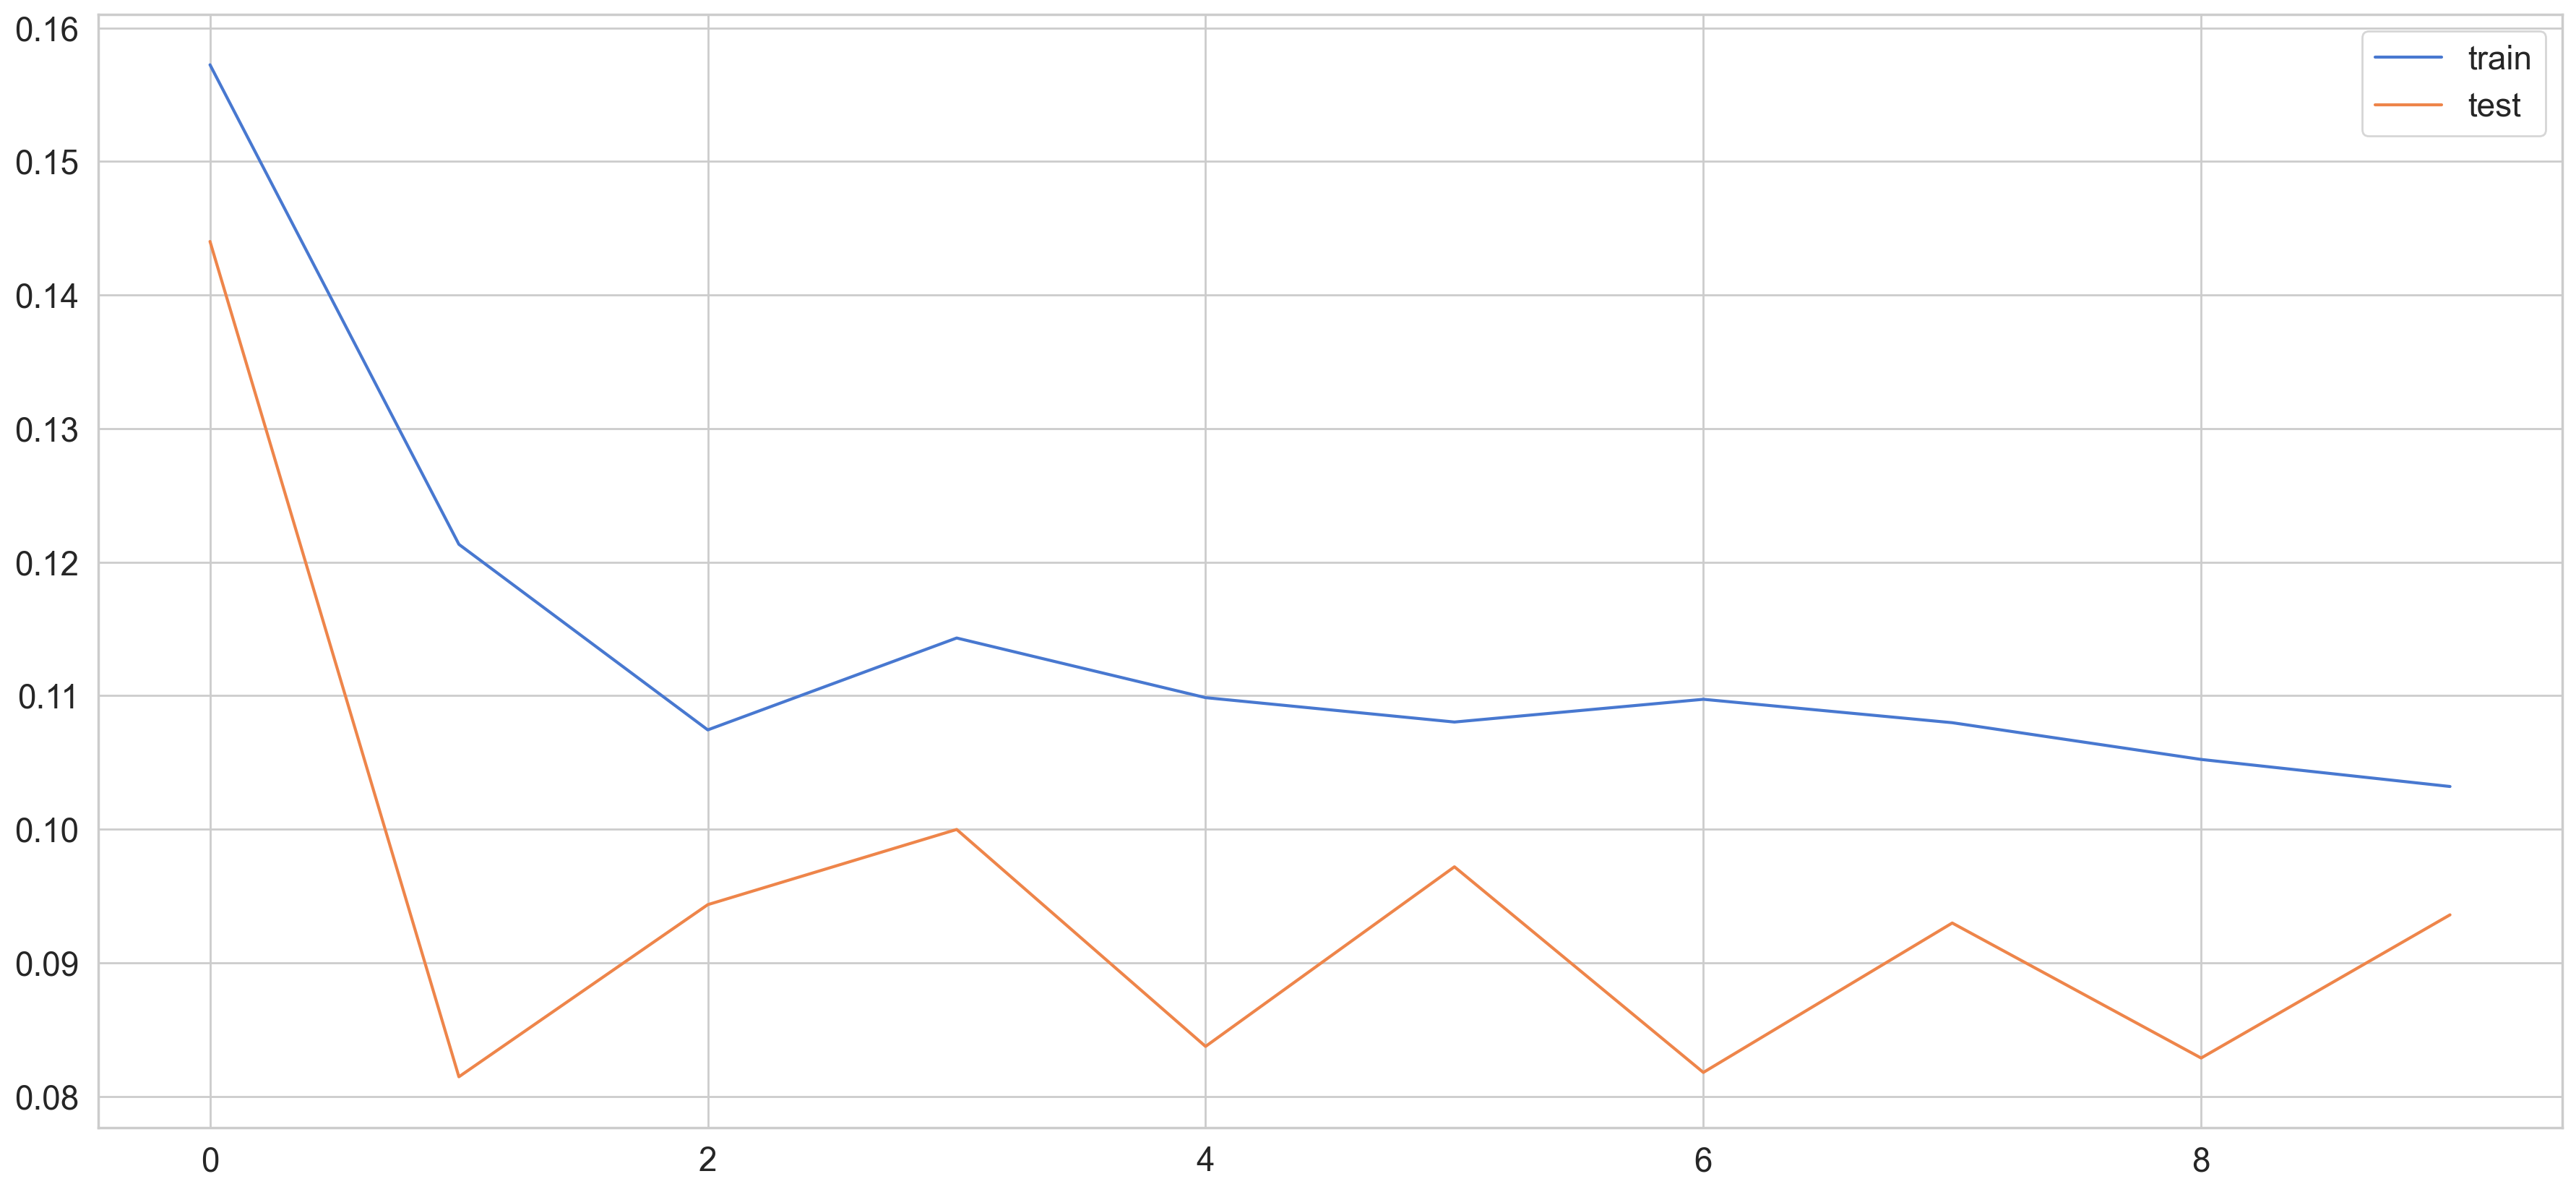

In [98]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()

In [99]:
X_train_pred = model.predict(X_train)

476/476 [==============================] - 197s 412ms/step


In [100]:
train_mae_loss = np.mean(np.abs(X_train_pred, X_train), axis=1)

In [101]:
train_mae_loss.shape

(15206, 1)

C:\Users\johanna4303\AppData\Local\Temp\ipykernel_620\4276719448.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True)


<Axes: ylabel='Density'>

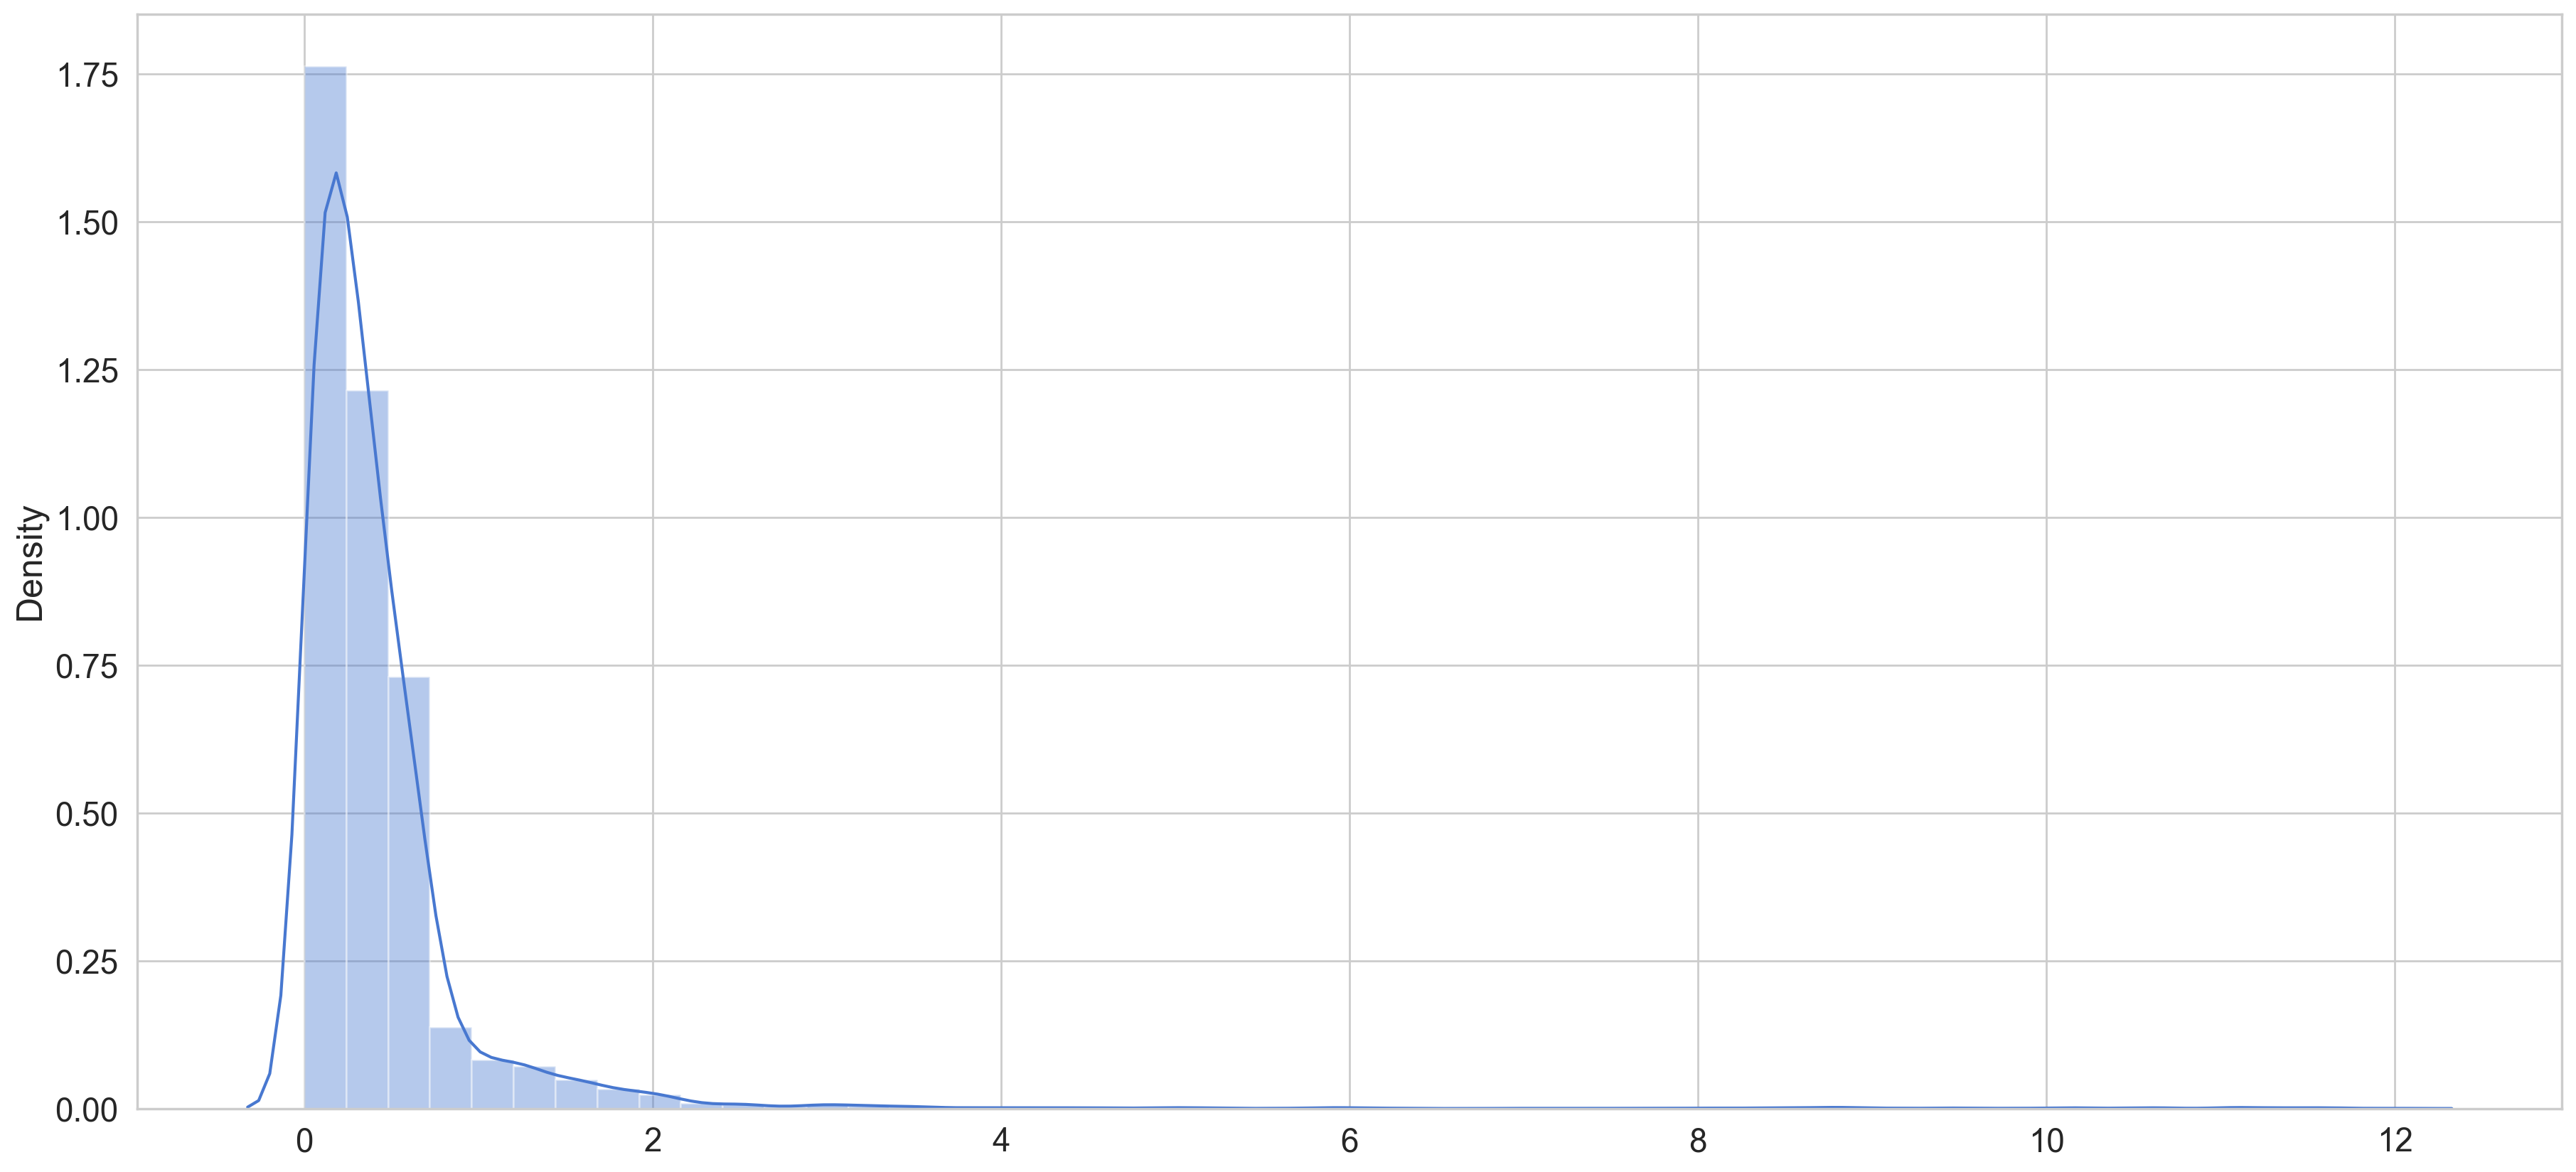

In [102]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [111]:
y_train

array([[0.59888622],
       [0.59888622],
       [0.59888622],
       ...,
       [1.53468459],
       [1.53468459],
       [1.4567014 ]])

In [103]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred, X_test), axis=1)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [31]:
THRESHOLD = 1.9

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df["loss"] = test_mae_loss
test_score_df["threshold"] = THRESHOLD
test_score_df["anomaly"] = test_score_df.loss > test_score_df.threshold
test_score_df["water_level"] = test[TIME_STEPS:]["Water level, Nap (cm)"]

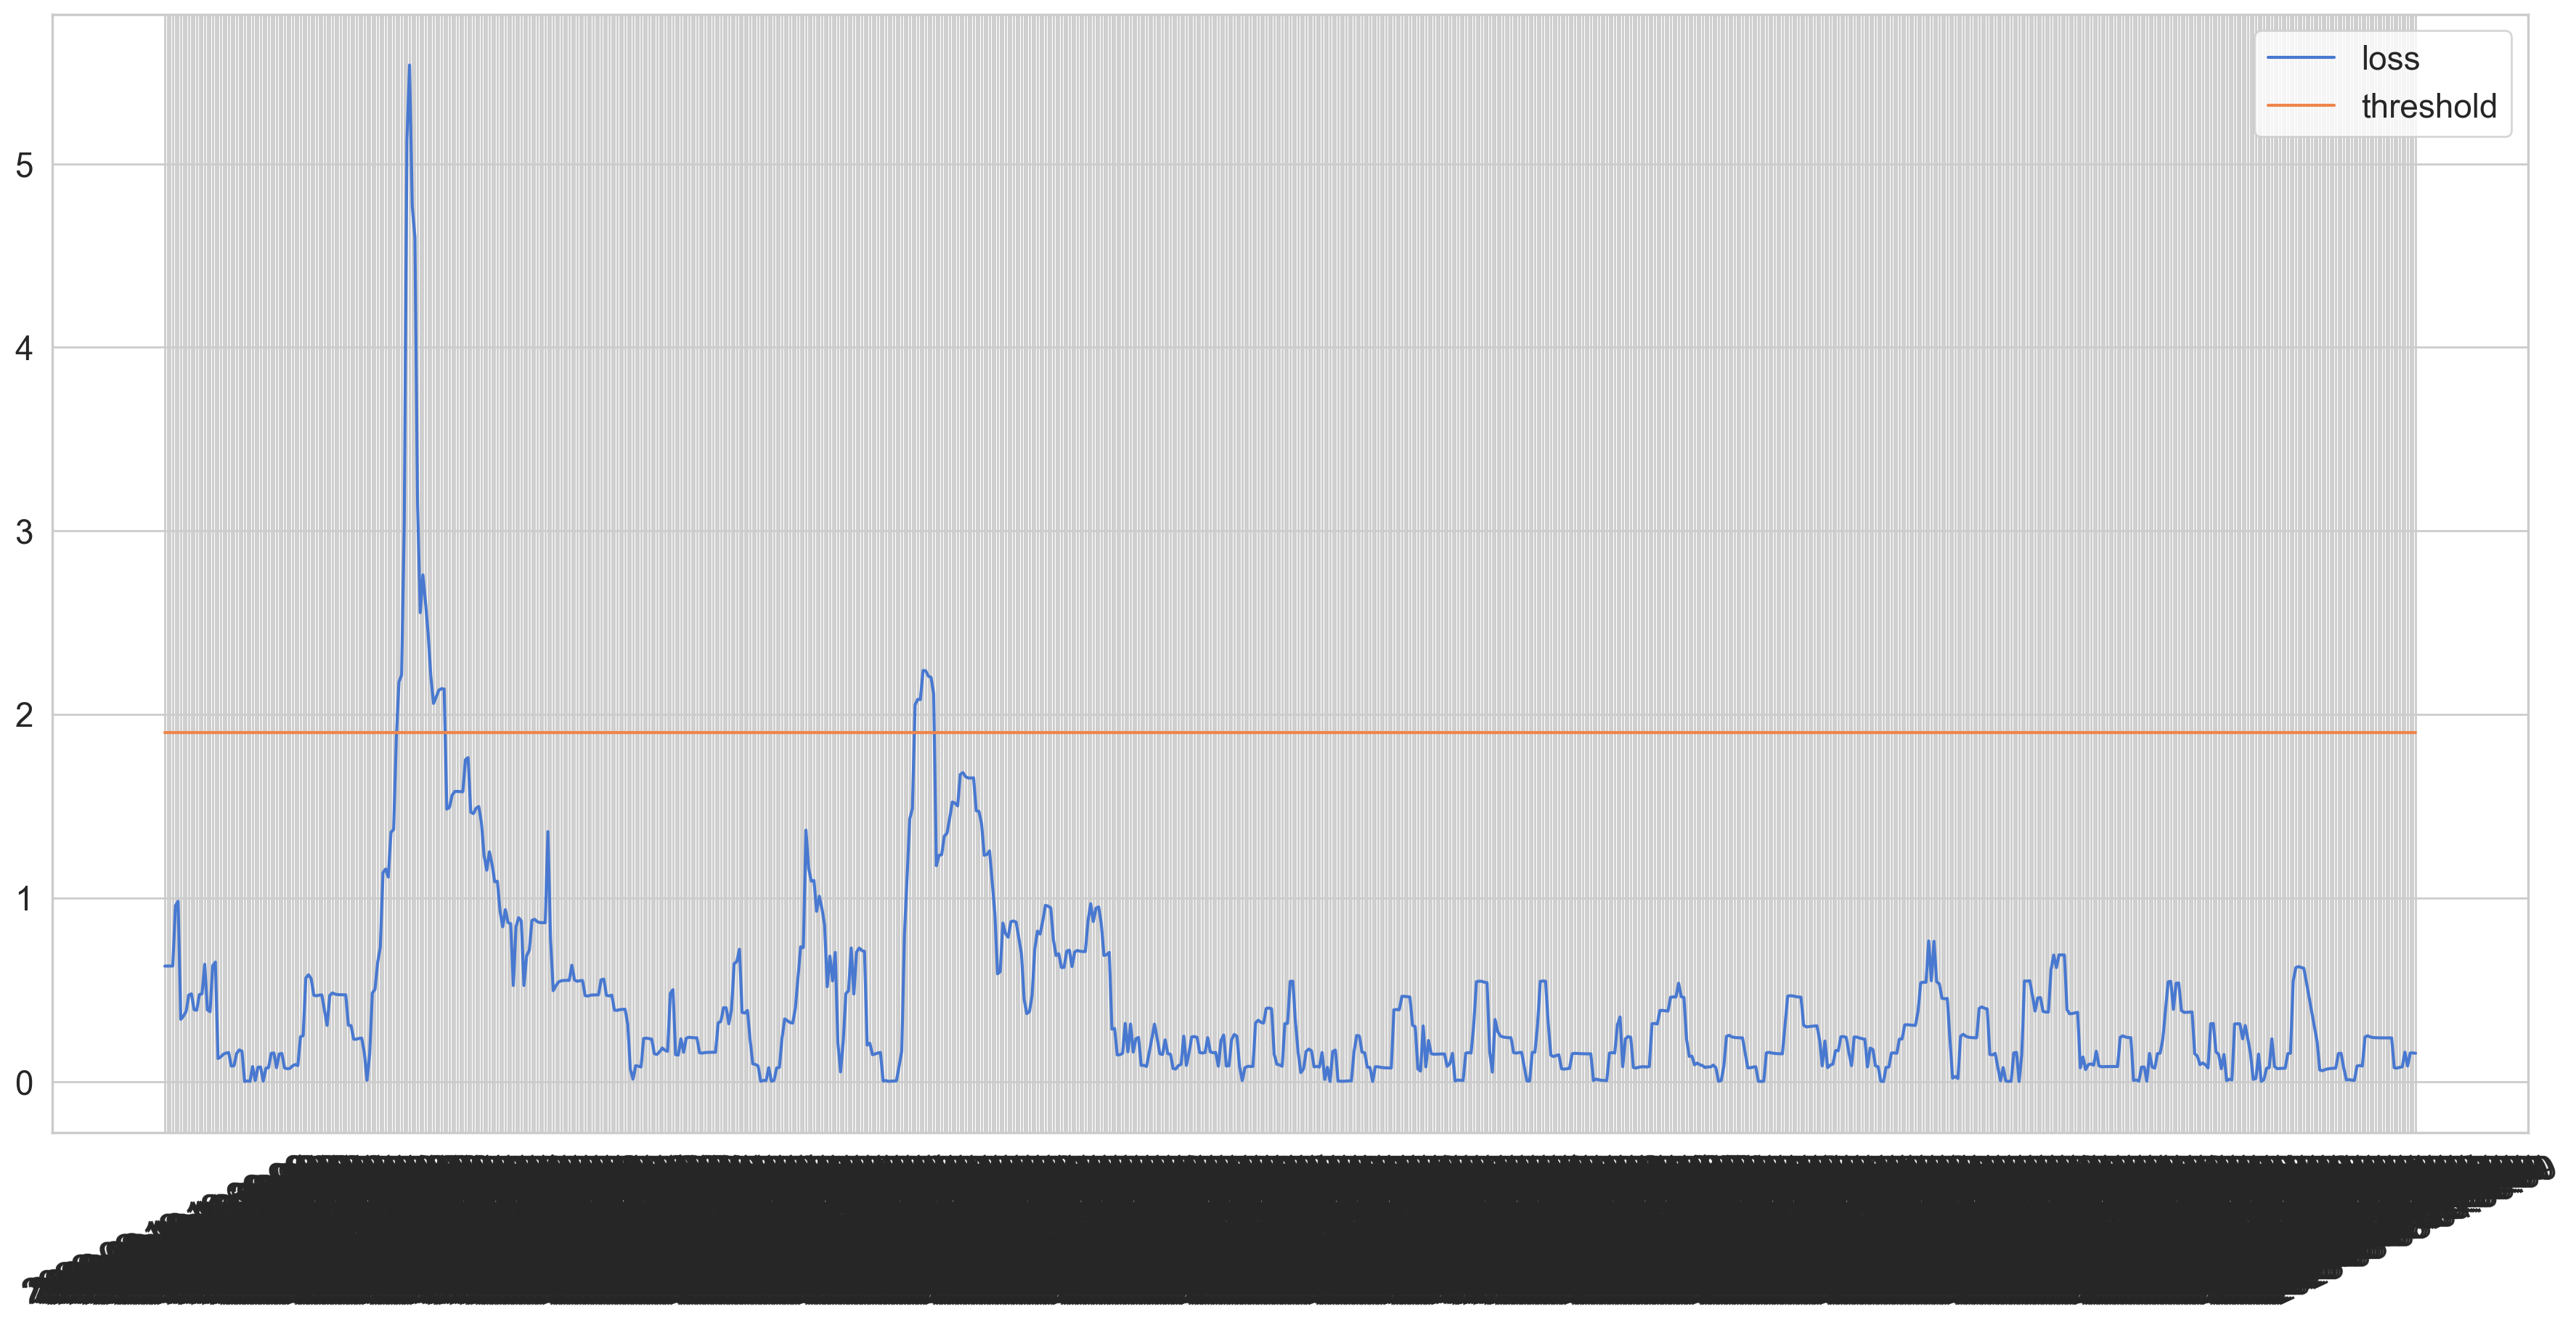

In [32]:
plt.plot(test_score_df.index, test_score_df.loss, label="loss")
plt.plot(test_score_df.index, test_score_df.threshold, label="threshold")
plt.xticks(rotation=25)
plt.legend()

Hopp i videon vid ca 25 minuter, kolla vad han gjorde.

In [33]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,water_level
Date/Time,,,,
2023-02-20 06:00:00,2.177157,1.9,True,2.080567
2023-02-20 06:30:00,2.214657,1.9,True,2.860399
2023-02-20 07:00:04,3.048171,1.9,True,4.654013
2023-02-20 07:30:00,5.129188,1.9,True,4.654013
2023-02-20 08:00:00,5.537986,1.9,True,4.654013
2023-02-20 08:30:00,4.769698,1.9,True,4.654013
2023-02-20 09:00:04,4.600257,1.9,True,3.562248
2023-02-20 09:30:00,3.147590,1.9,True,2.938382
2023-02-20 10:00:00,2.554472,1.9,True,2.938382


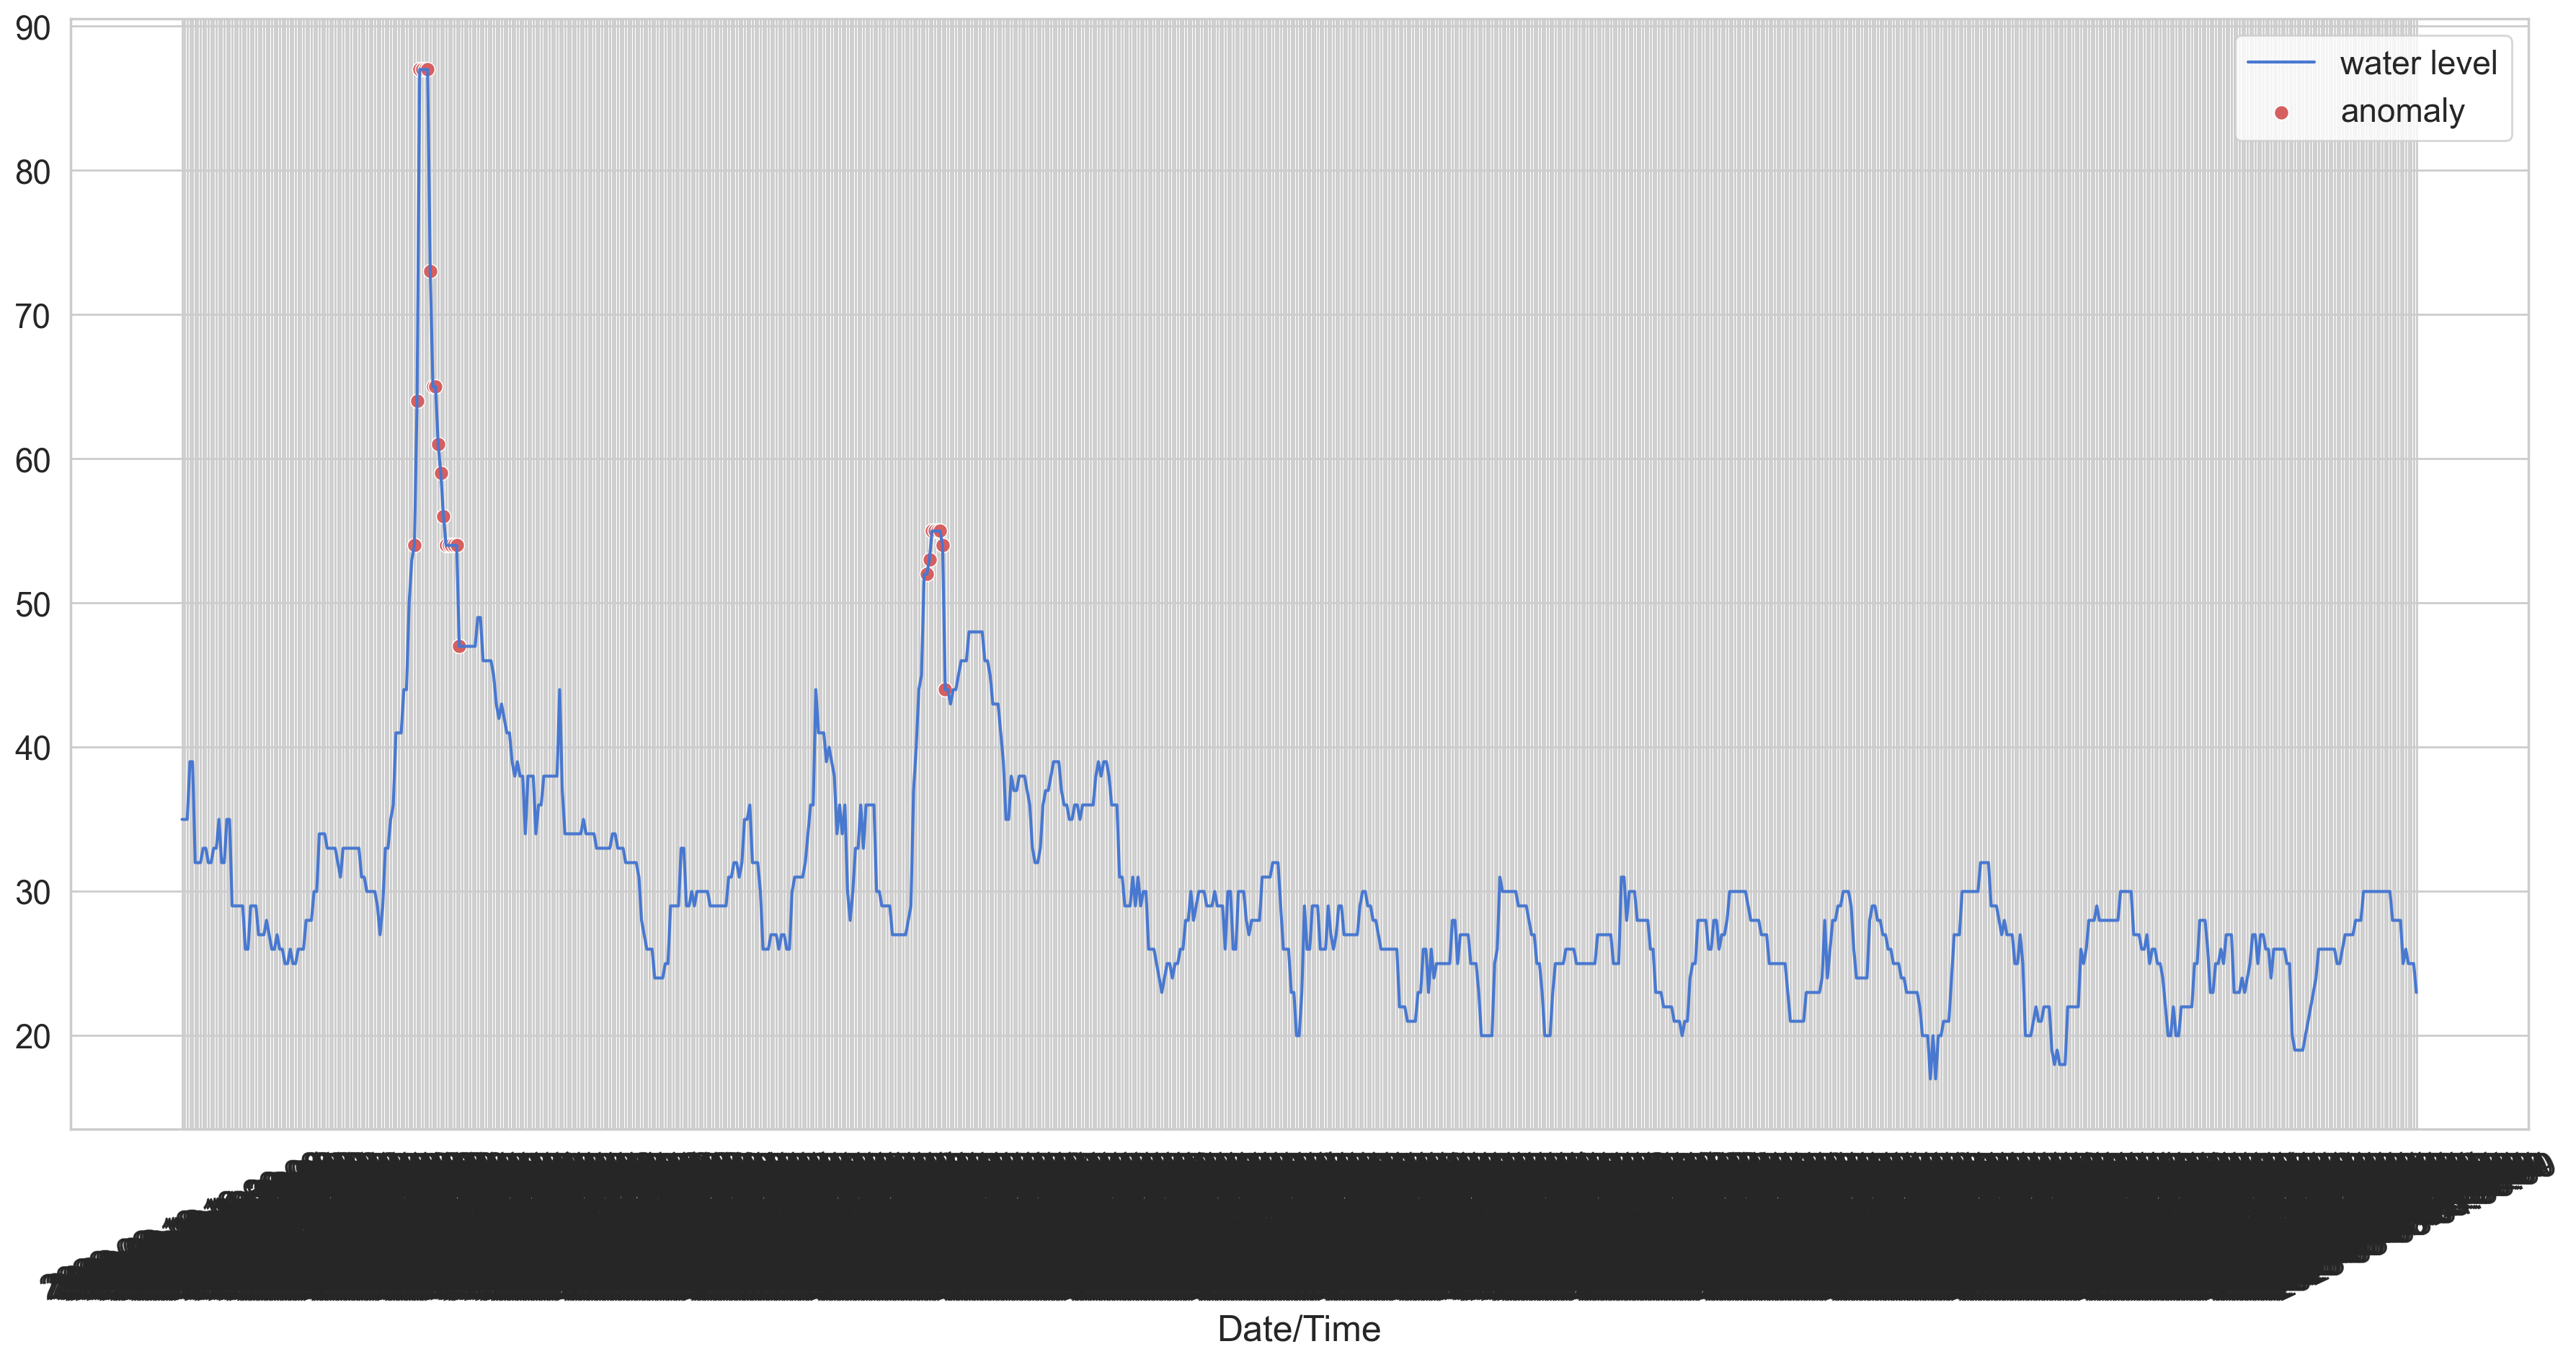

In [69]:
# Testar här det som inte var med i videon men som ligger på GitHub
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:]["Water level, Nap (cm)"].values.reshape((-1, 1))),
    label="water level"
)

sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies.water_level.values.reshape((-1, 1))).flatten(),
    color=sns.color_palette()[3],
    s=52,
    label="anomaly"
)

plt.xticks(rotation=25)
plt.legend()

In [34]:
# Härifrån och neråt är det som var på tutorialen, inklusive egna printar
test[TIME_STEPS:]["Water level, Nap (cm)"]

Date/Time
2023-02-18 10:00:00    0.598886
2023-02-18 10:30:00    0.598886
2023-02-18 11:00:00    0.598886
2023-02-18 11:30:04    0.910819
2023-02-18 12:00:00    0.910819
                         ...   
2023-03-07 23:00:00   -0.102963
2023-03-07 23:30:00   -0.180946
2023-03-08 00:00:04   -0.180946
2023-03-08 00:30:00   -0.180946
2023-03-08 01:00:00   -0.336912
Name: Water level, Nap (cm), Length: 847, dtype: float64

In [35]:
reshaped_scaler = scaler.inverse_transform(anomalies["water_level"].values.reshape((-1, 1)))
reshaped_scaler.shape

(26, 1)

In [43]:
test_water_level = test[TIME_STEPS:]["Water level, Nap (cm)"].values
test_water_level = test_water_level.reshape((-1, 1))
scatter_x = anomalies.index
scatter_x = pd.Series(scatter_x)
scatter_y = scaler.inverse_transform(anomalies["water_level"].values.reshape((-1, 1)))

print(f"{scatter_x.dtype}")
print(scatter_x.shape)
print(f"{scatter_y.dtype}")
print(scatter_y.shape)

object
(26,)
float64
(26, 1)


In [40]:
scatter_df = pd.concat([scatter_x, scatter_y], axis=1)
data = scatter_df.to_numpy()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

Jag behöver plotta ut anomalies i sns.scatterplot som verkar vilja ha x och y i 2d. När jag gör det får jag dock ett felmeddelande om att per-column arrays must always be one dimensional. Suck.

NameError: name 'data' is not defined

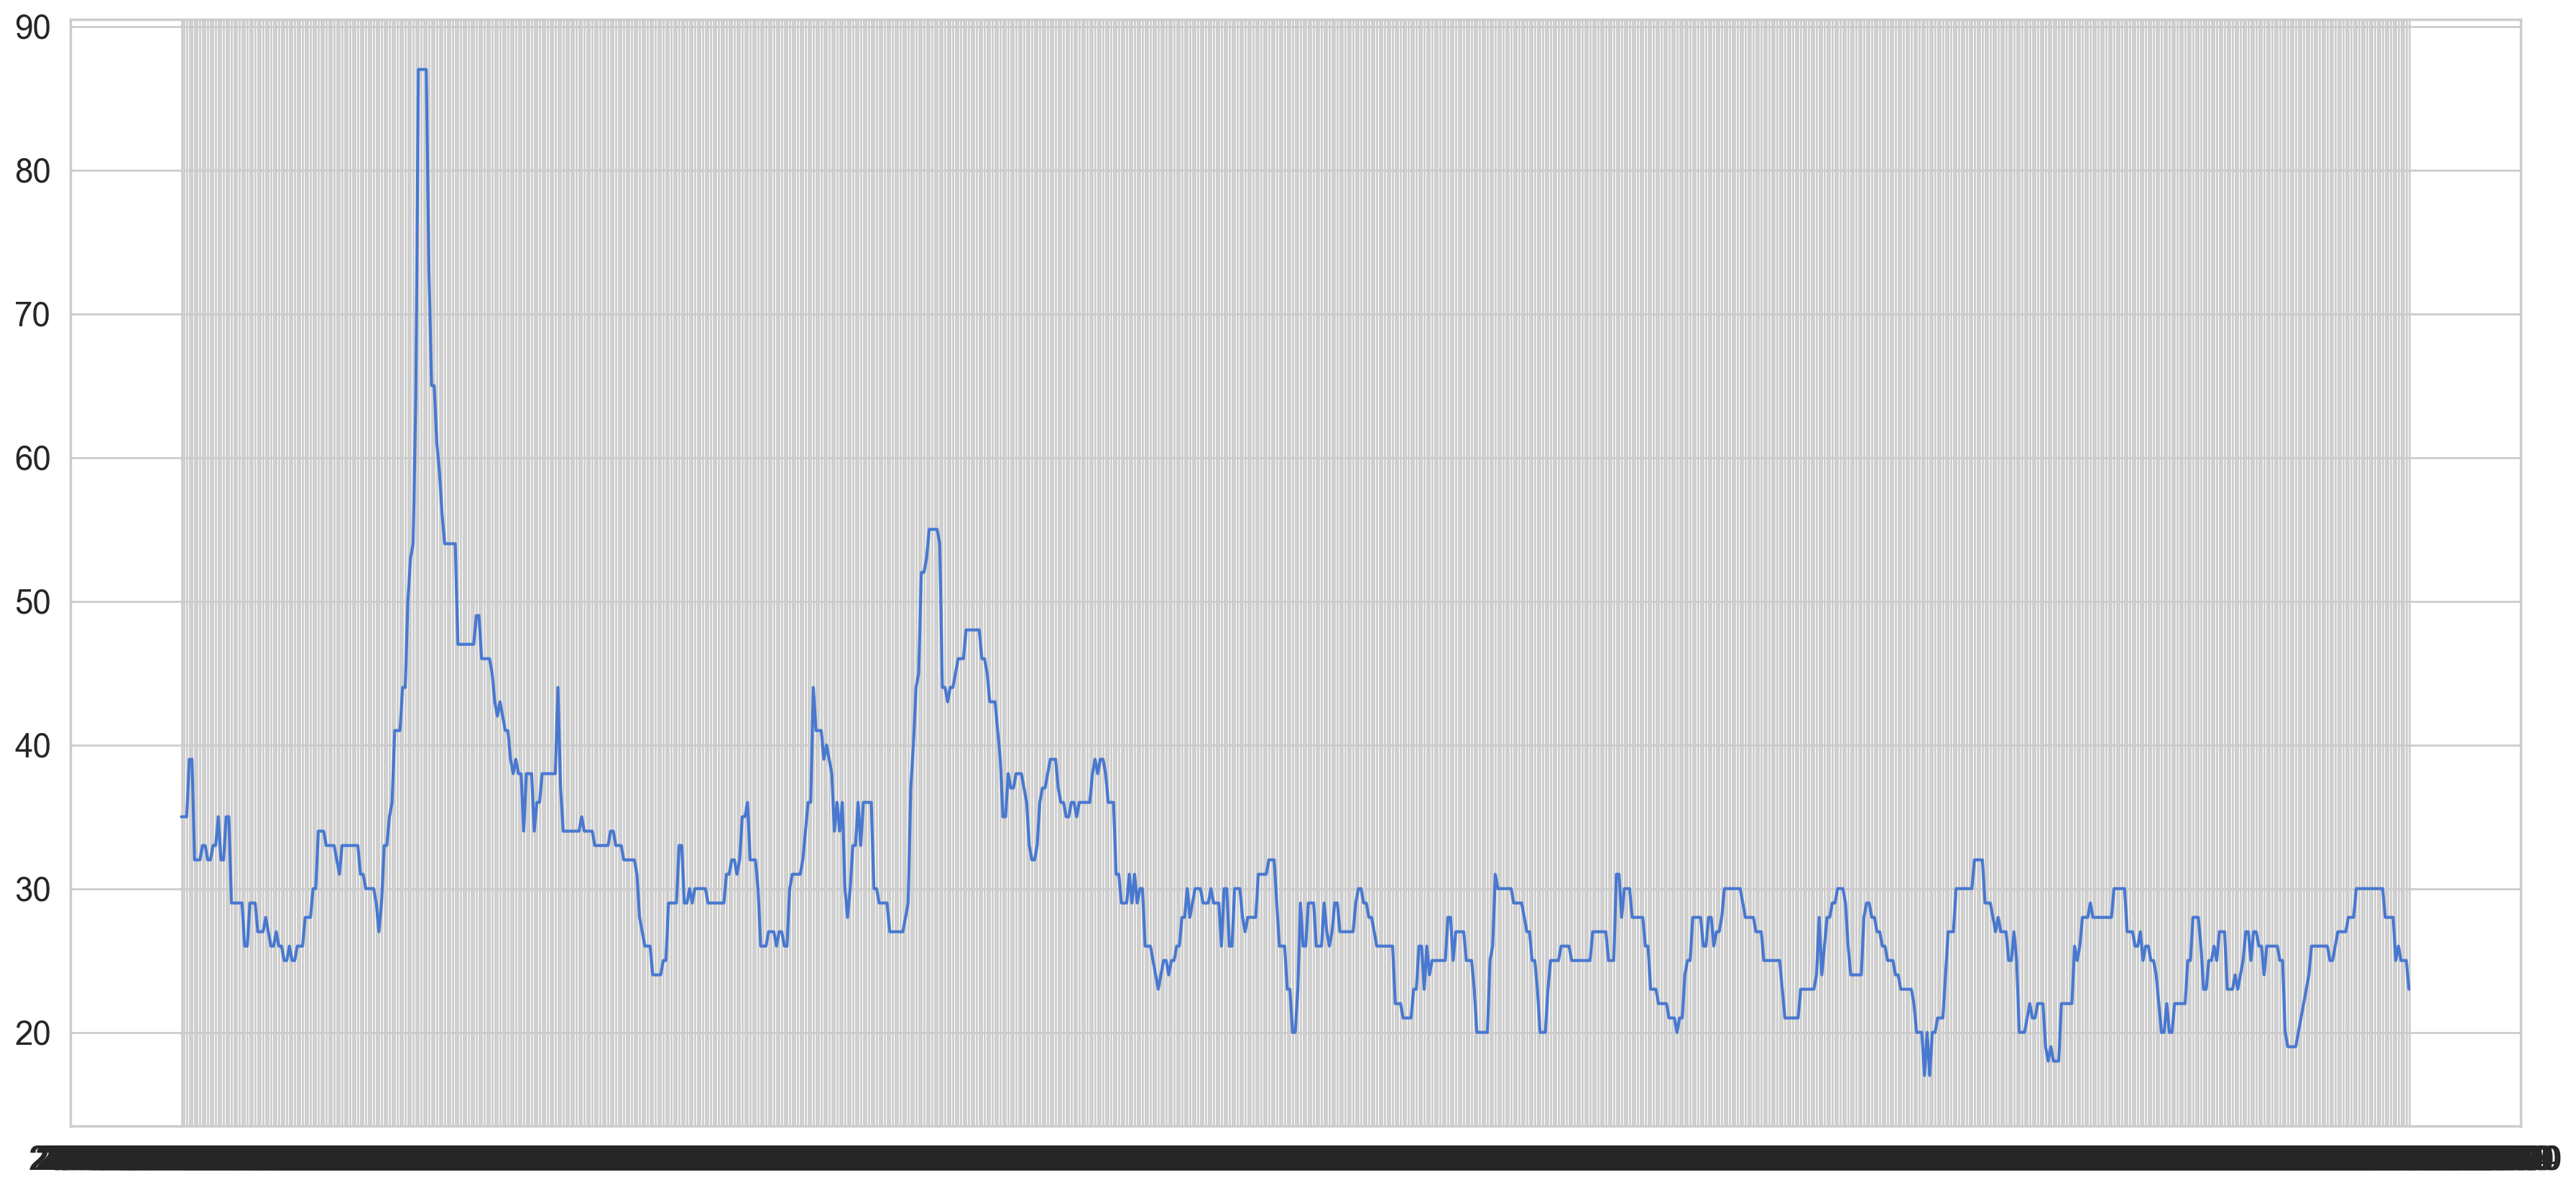

In [37]:


plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test_water_level),
    label="Water level, Nap (cm)"
)

sns.scatterplot(
    # scaler.inverse_transform(anomalies["water_level"].values.reshape((-1, 1))),
    x=data[:,0],
    y=data[:,1],
    color=sns.color_palette()[3],
    s=52,
    label="anomaly"
)

plt.xticks(rotation=25)
plt.legend

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"units": sp_randint(50, 500),
              "dropout": [0.1, 0.2, 0.3, 0.4],
              "optimizer": ["adam", "rmsprop"]}

In [ ]:
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10)
random_search.fit(X_train, y_train)

In [ ]:
print(random_search.best_params_)

In [ ]:
best_model = create_model(units=random_search.best_params_["units"], dropout=random_search.best_params_["dropout"], optimizer=random_search.best_params_["optimizer"])
best_model.fit(X_train, y_train, epochs=5, batch_size=32)